In [1]:
import fnmatch
import glob
import os
import re
from time import sleep
from zipfile import ZipFile
from datetime import datetime, timedelta
import requests
session = requests.Session()

from requests_html import HTMLSession
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm  # progress bar on loops
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import PyPDF2
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
xlb = pd.read_csv('ETFdata/XLB.csv')
xle = pd.read_csv('ETFdata/XLE.csv')
xlf = pd.read_csv('ETFdata/XLF.csv')
xli = pd.read_csv('ETFdata/XLI.csv')
xlk = pd.read_csv('ETFdata/XLK.csv')
xlp = pd.read_csv('ETFdata/XLP.csv')
xlre = pd.read_csv('ETFdata/XLRE.csv')
xlu = pd.read_csv('ETFdata/XLU.csv')
xlv = pd.read_csv('ETFdata/XLV.csv')
xly = pd.read_csv('ETFdata/XLY.csv')
xlc = pd.read_csv('ETFdata/XLc.csv')


In [3]:
dfs = pd.concat([xlb, xle, xlf, xli, xlk, xlp, xlre, xlu, xlv, xly, xlc], ignore_index=True)
dfs


Ticker       Date       Open       High        Low      Close  Adj Close  \
0       XLB   2021/9/7  85.070000  85.129997  84.690002  84.809998  81.769379   
1       XLB   2021/9/8  84.559998  84.639999  83.709999  84.000000  80.988419   
2       XLB   2021/9/9  83.760002  84.599998  83.760002  84.029999  81.017342   
3       XLB  2021/9/10  84.419998  85.050003  83.959999  84.010002  80.998062   
4       XLB  2021/9/13  84.750000  85.000000  83.459999  83.989998  80.978775   
...     ...        ...        ...        ...        ...        ...        ...   
3834    XLC  2023/1/19  50.970001  51.755001  50.799999  51.490002  51.349598   
3835    XLC  2023/1/20  51.910000  53.155998  51.770000  53.099998  52.955204   
3836    XLC  2023/1/23  53.150002  54.154999  53.020000  54.029999  53.882671   
3837    XLC  2023/1/24  53.580002  54.650002  53.412998  53.880001  53.733082   
3838    XLC  2023/1/25  53.500000  54.189999  53.310001  54.070000  53.922562   

       Volume  Return  
0     6932300     NaN  
1     6210000 -0.0100  
2     4935700  0.0000  
3     8890100  0.0000  
4     7610000  0.0000  
...       ...     ...  
3834  7387400  0.0051  
3835  4874200  0.0313  
3836  6279000  0.0175  
3837  8867000 -0.0028  
3838  4976800  0.0035  

[3839 rows x 9 columns]

In [4]:
announce_date = pd.DataFrame({'Date': ['2021/09/24', '2021/11/09', '2021/11/29', '2022/03/21', '2022/05/24', '2022/06/17', '2022/08/26', '2022/09/28', '2022/11/30', '2023/01/11']})
announce_date['Date'] = pd.to_datetime(announce_date['Date'])

In [5]:
dfs['Date'] = pd.to_datetime(dfs['Date'])

In [6]:
df = pd.merge(dfs, announce_date, on='Date')

dates = pd.date_range(df['Date'].min()-pd.Timedelta(days=10), df['Date'].max()+pd.Timedelta(days=10), freq='D')

returns = []
for date in dates:
    for ticker in dfs['Ticker'].unique():
        mask = (dfs['Date'] == date) & (dfs['Ticker'] == ticker)
        df_temp = dfs.loc[mask, :]
        if not df_temp.empty:
            returns.append({'Ticker': ticker, 'Date': date, 'Return': df_temp['Return'].values[0]})
        

returns = pd.DataFrame(returns)
print(returns)

     Ticker       Date  Return
0       XLB 2021-09-14 -0.0110
1       XLE 2021-09-14 -0.0140
2       XLF 2021-09-14 -0.0134
3       XLI 2021-09-14 -0.0120
4       XLK 2021-09-14 -0.0010
...     ...        ...     ...
3746   XLRE 2023-01-20  0.0116
3747    XLU 2023-01-20  0.0060
3748    XLV 2023-01-20  0.0050
3749    XLY 2023-01-20  0.0242
3750    XLC 2023-01-20  0.0313

[3751 rows x 3 columns]


In [7]:
# Define the events
event_dates = {'Event 1': ['2021/09/14', '2021/10/04'],
               'Event 2': ['2021/10/30', '2021/11/19'],
               'Event 3': ['2021/11/19', '2021/12/09'],
               'Event 4': ['2022/03/11', '2022/03/31'],
               'Event 5': ['2022/05/14', '2022/06/03'],
               'Event 6': ['2022/06/07', '2022/06/27'],
               'Event 7': ['2022/08/16', '2022/09/05'],
               'Event 8': ['2022/09/18', '2022/10/08'],
               'Event 9': ['2022/11/20', '2022/12/10'],
               'Event 10': ['2023/01/01', '2023/01/21']}

# Convert date strings to datetime objects
for event, dates in event_dates.items():
    event_dates[event] = [pd.to_datetime(date) for date in dates]

# Add Event column to returns DataFrame
returns['Event'] = ''
for event, dates in event_dates.items():
    start_date, end_date = dates
    mask = (returns['Date'] >= start_date - pd.Timedelta(days=10)) & \
           (returns['Date'] <= end_date + pd.Timedelta(days=10))
    returns.loc[mask, 'Event'] = event

returns
returns.to_csv('analysis csv file/returns.csv', index=False)

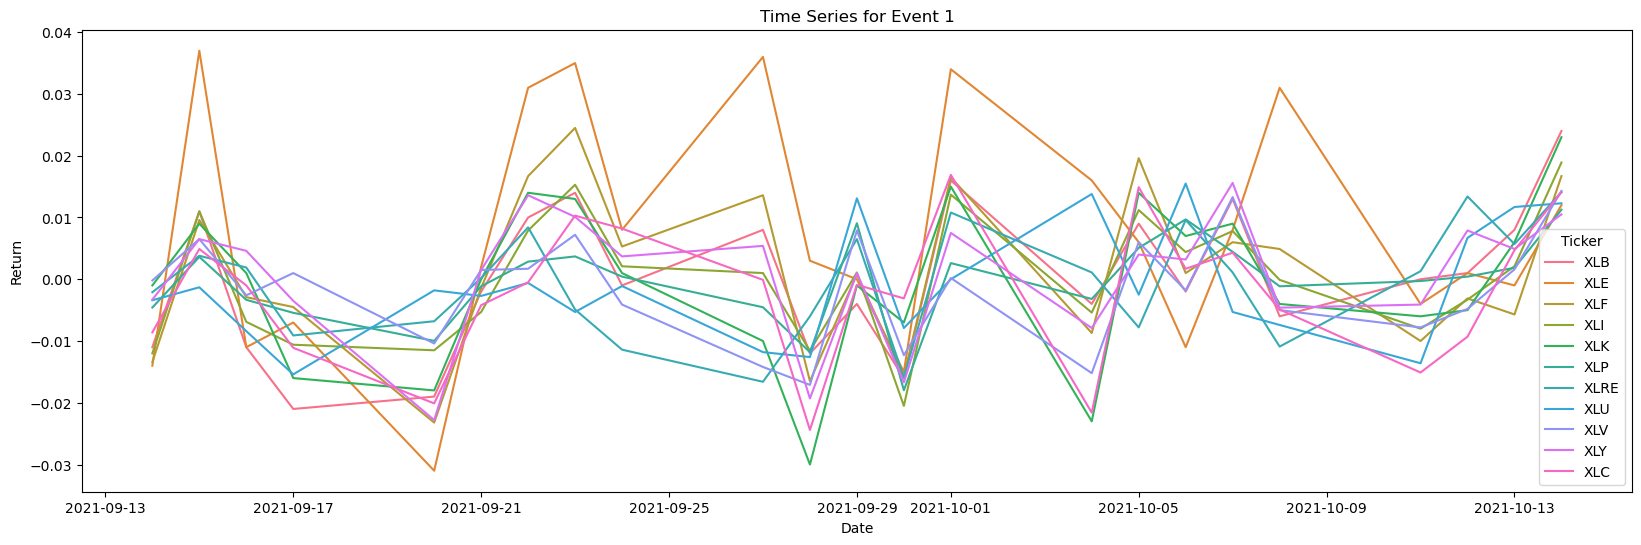

In [8]:
event1_returns = returns.query('Event == "Event 1"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 1")
sns.lineplot(data=event1_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

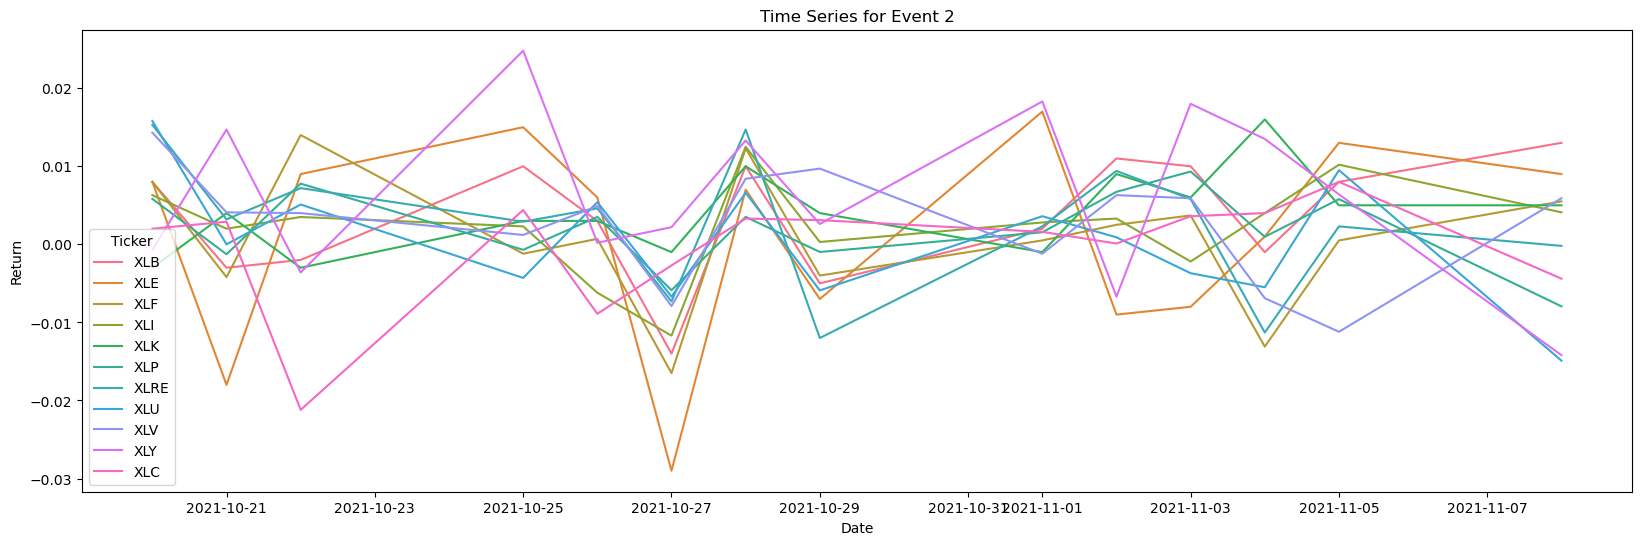

In [9]:
event2_returns = returns.query('Event == "Event 2"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 2")
sns.lineplot(data=event2_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

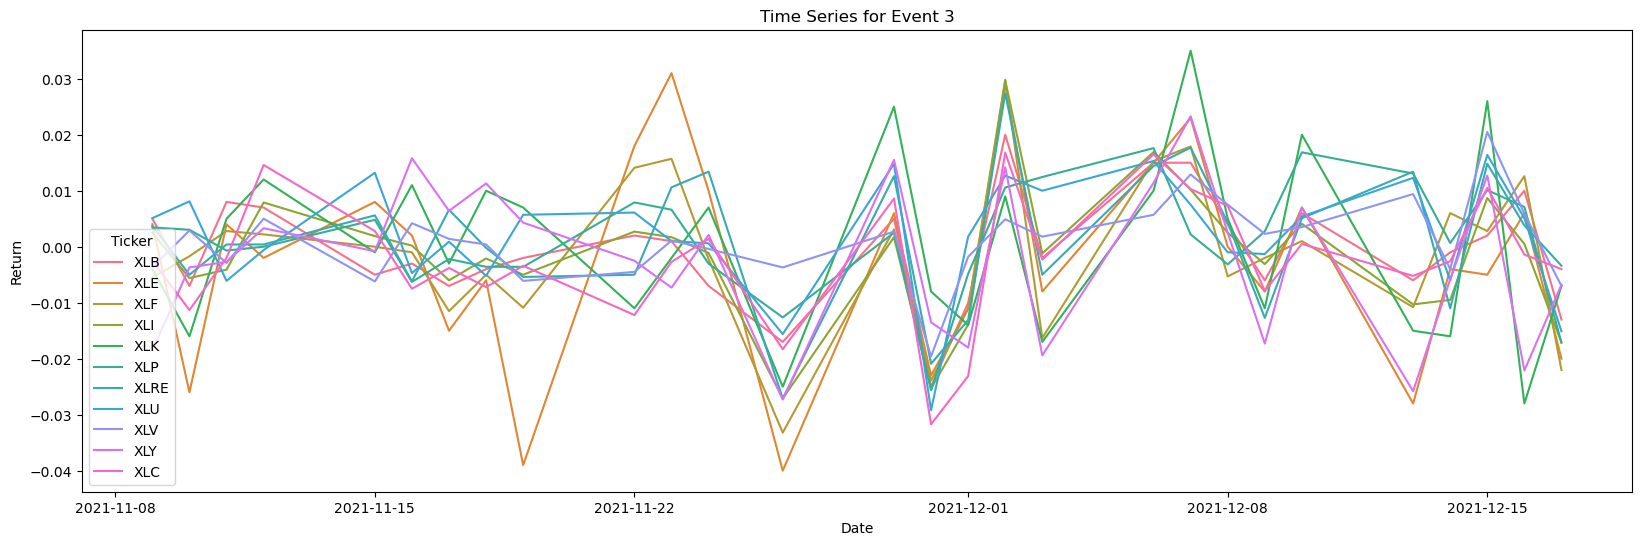

In [10]:
event3_returns = returns.query('Event == "Event 3"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 3")
sns.lineplot(data=event3_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

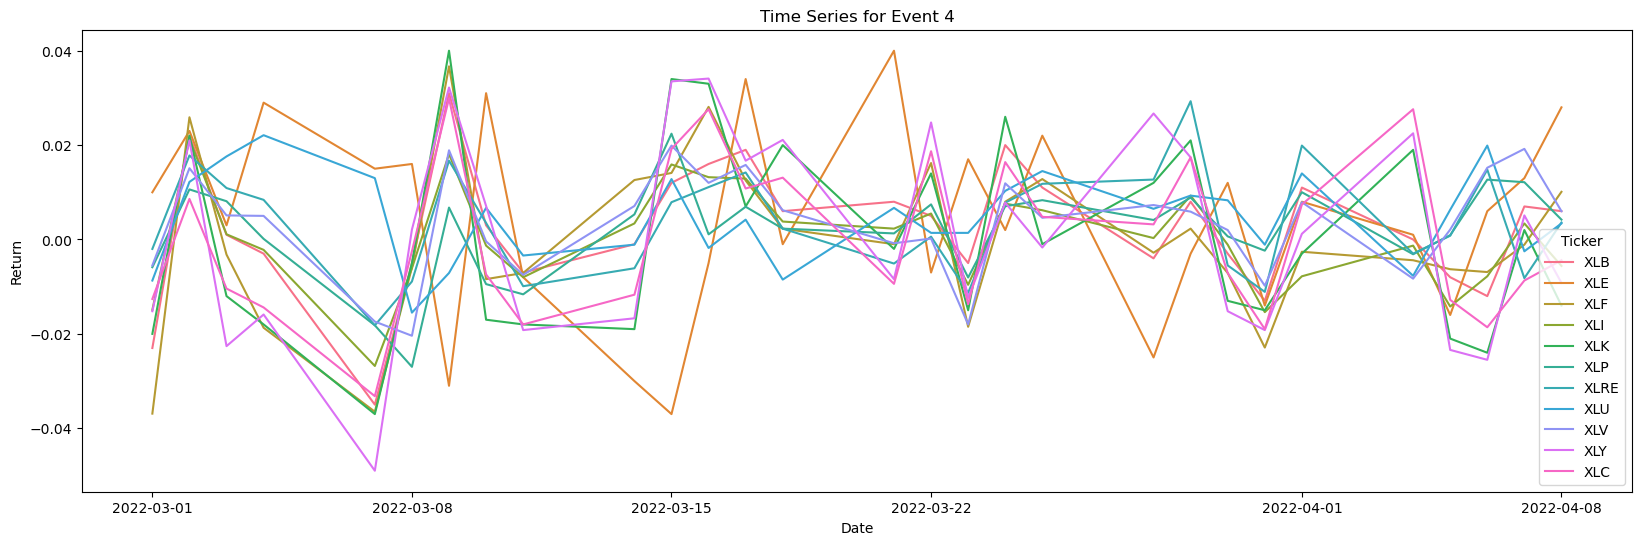

In [11]:
event4_returns = returns.query('Event == "Event 4"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 4")
sns.lineplot(data=event4_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

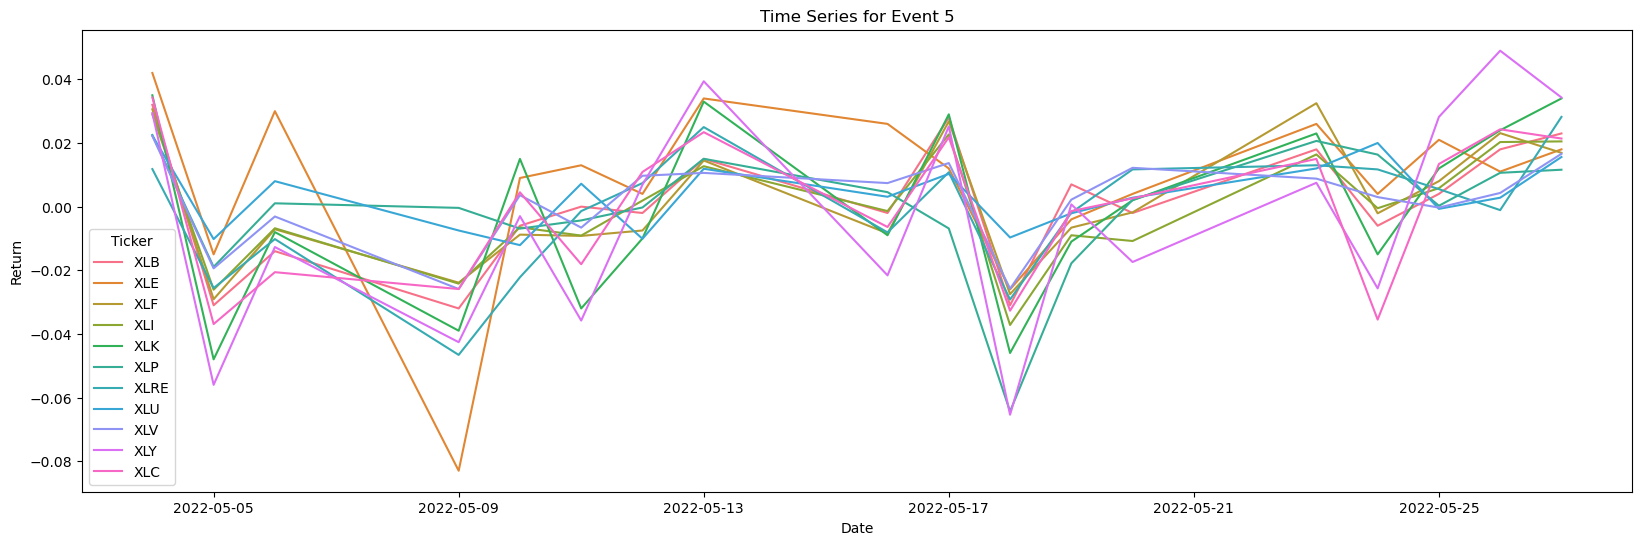

In [12]:
event5_returns = returns.query('Event == "Event 5"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 5")
sns.lineplot(data=event5_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

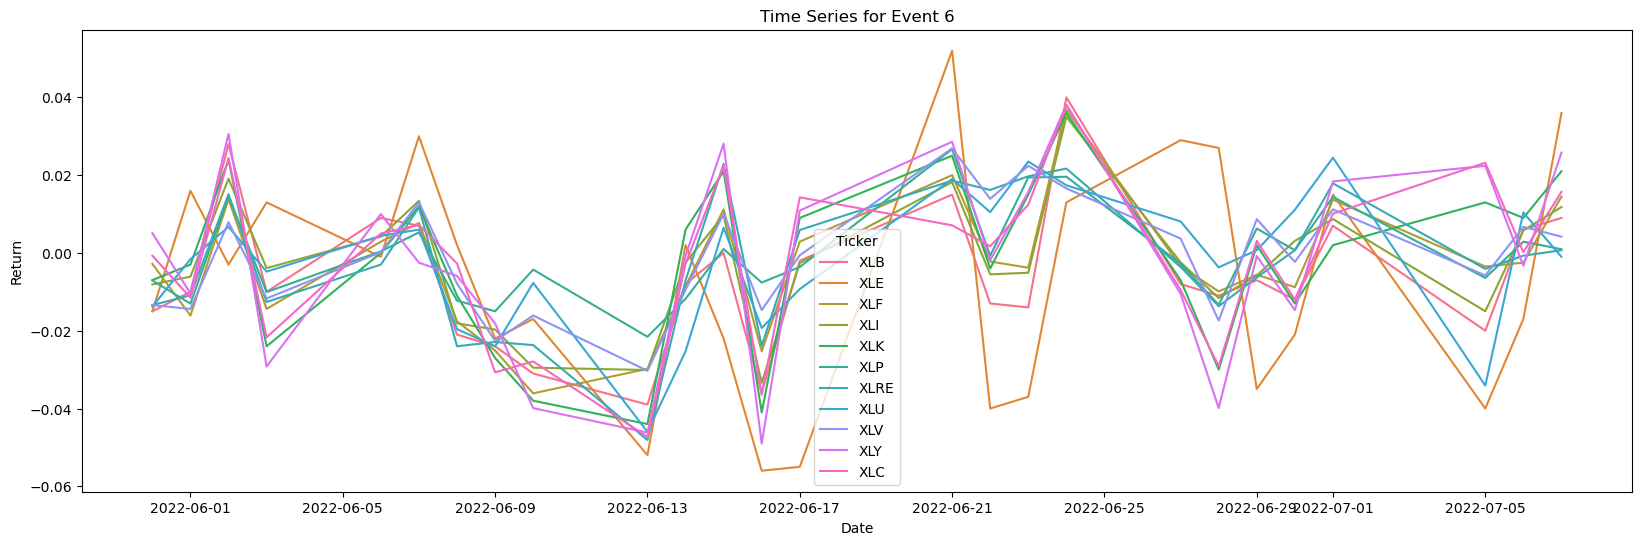

In [13]:
event6_returns = returns.query('Event == "Event 6"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 6")
sns.lineplot(data=event6_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

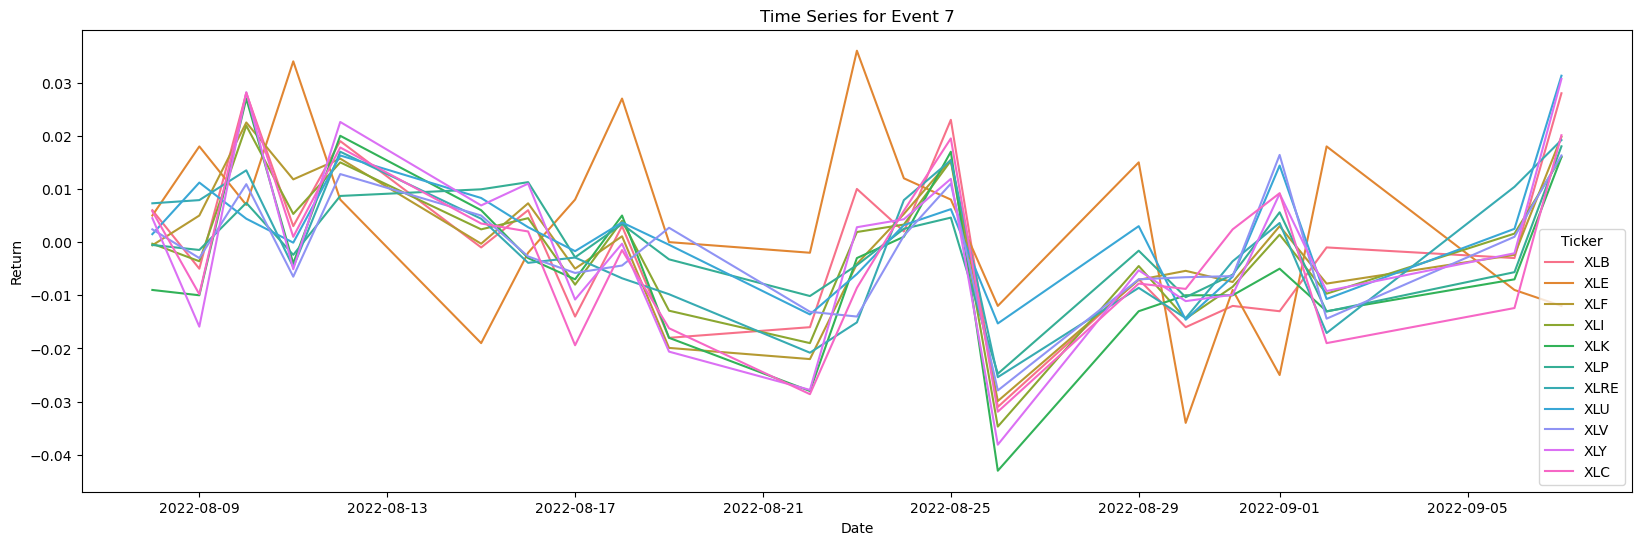

In [14]:
event7_returns = returns.query('Event == "Event 7"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 7")
sns.lineplot(data=event7_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

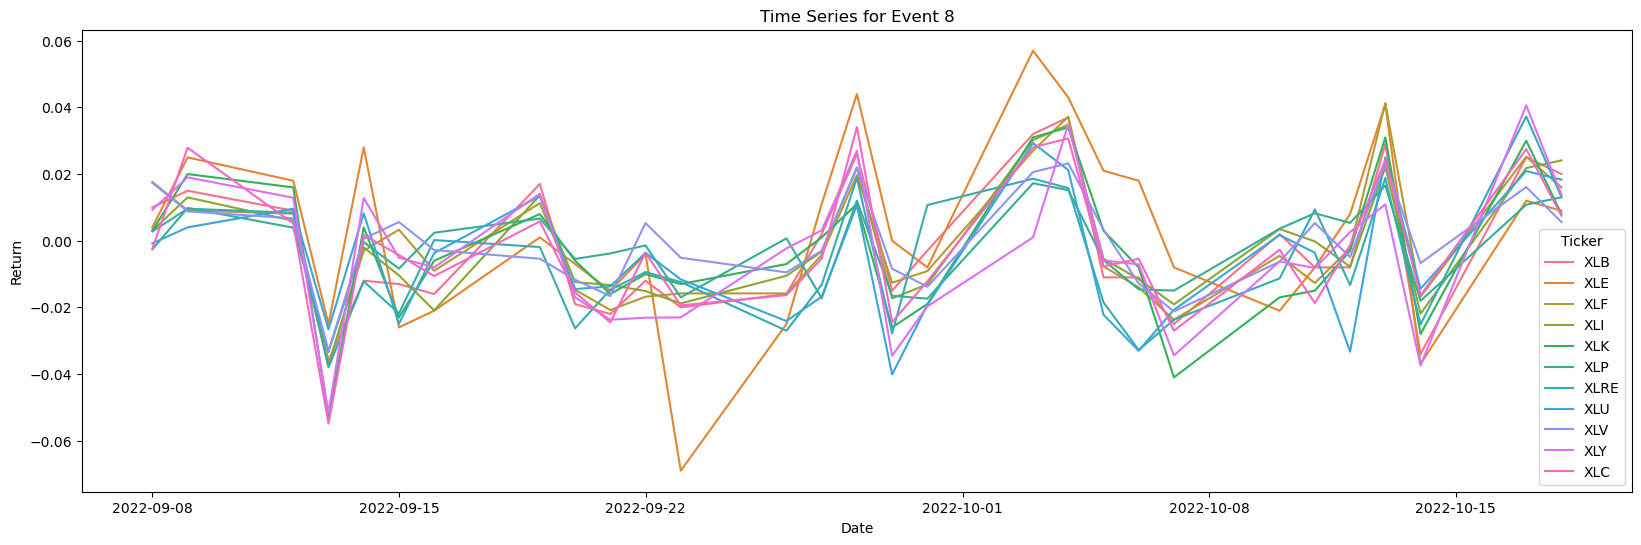

In [15]:
event8_returns = returns.query('Event == "Event 8"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 8")
sns.lineplot(data=event8_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

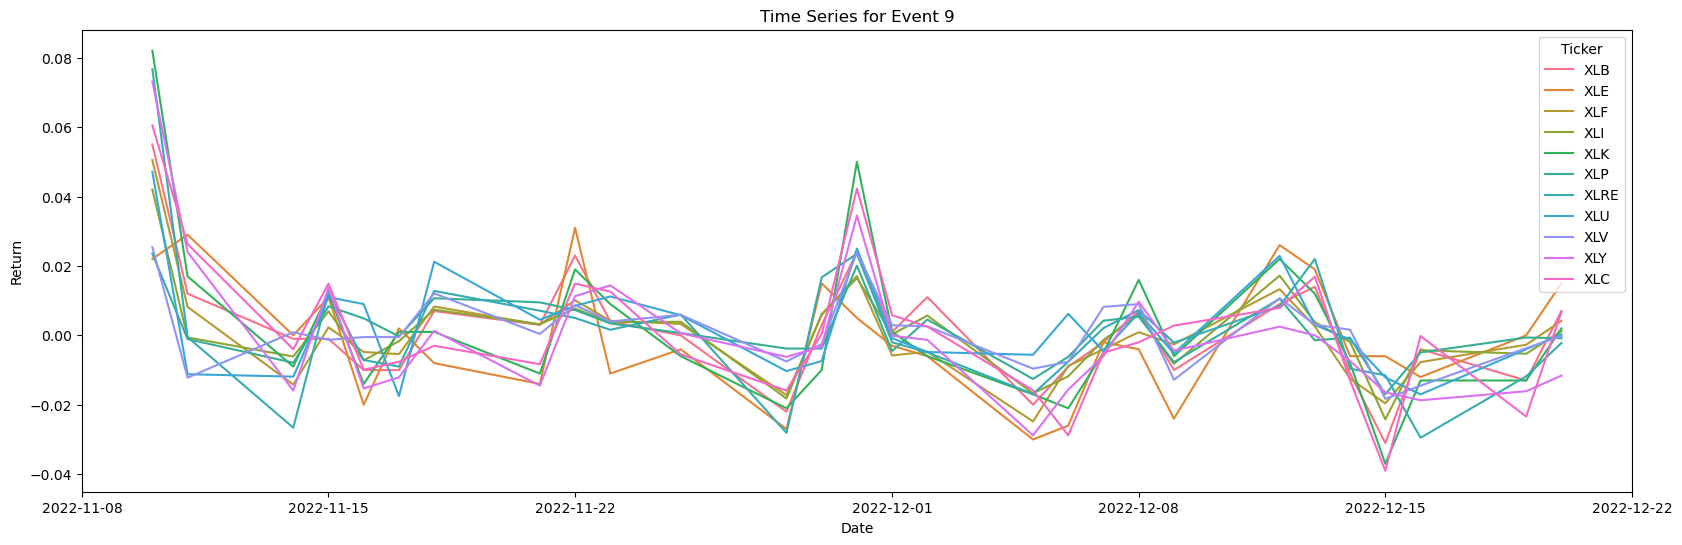

In [16]:
event9_returns = returns.query('Event == "Event 9"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 9")
sns.lineplot(data=event9_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

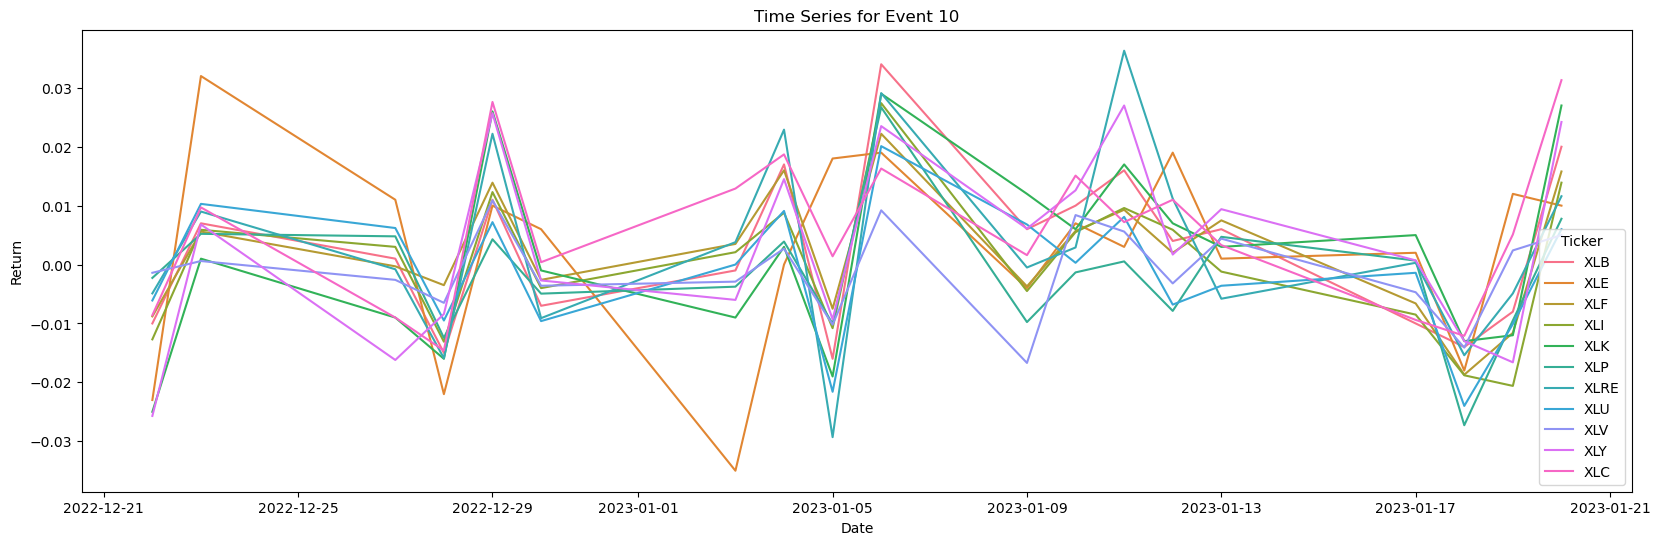

In [17]:
event10_returns = returns.query('Event == "Event 10"')
plt.figure(figsize=(20, 6))
plt.title("Time Series for Event 10")
sns.lineplot(data=event10_returns, x='Date', y='Return', hue='Ticker')
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

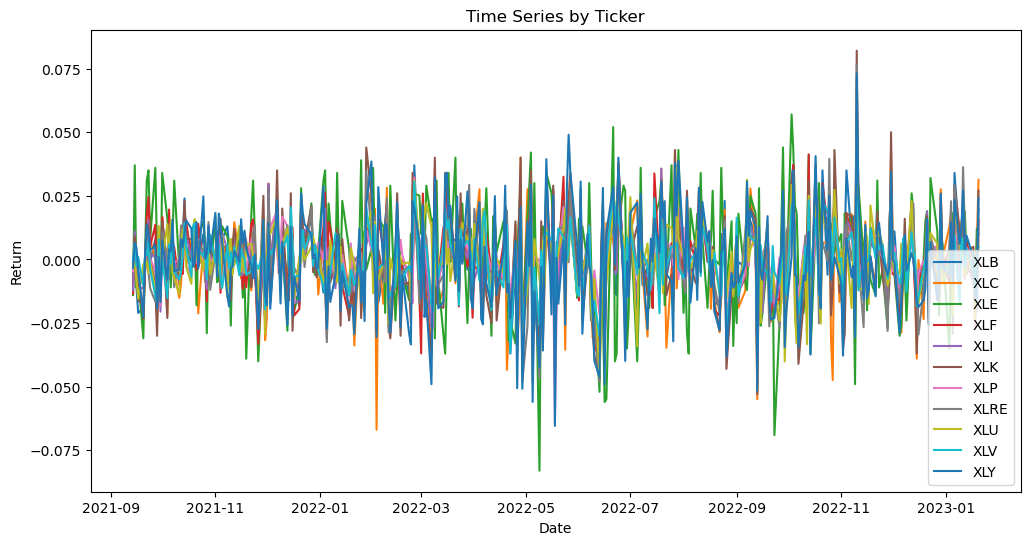

In [18]:
ticker_group = returns.groupby('Ticker')

fig, ax = plt.subplots(figsize=(12, 6))
for ticker, data in ticker_group:
    ax.plot(data['Date'], data['Return'], label=ticker)

ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title('Time Series by Ticker')
ax.legend()

plt.show()

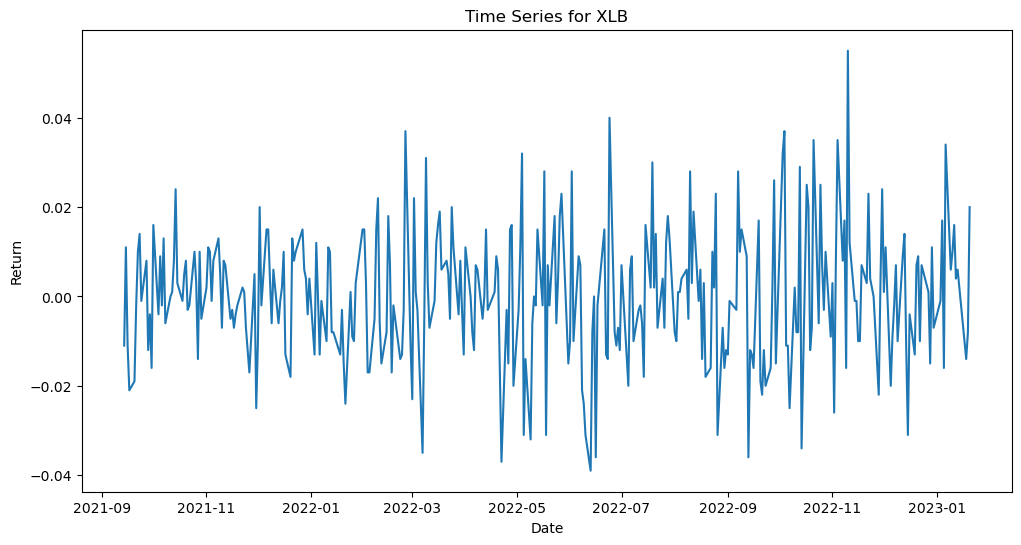

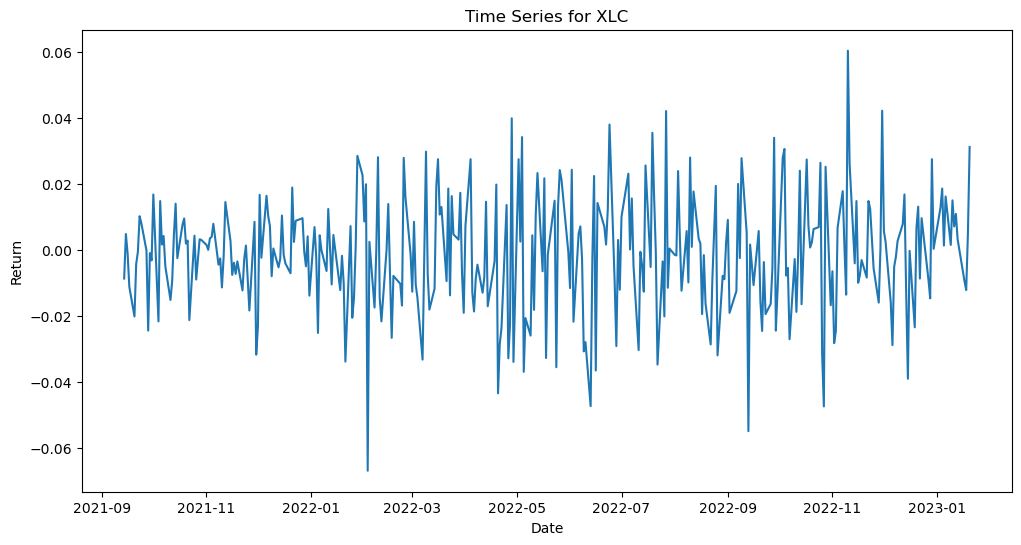

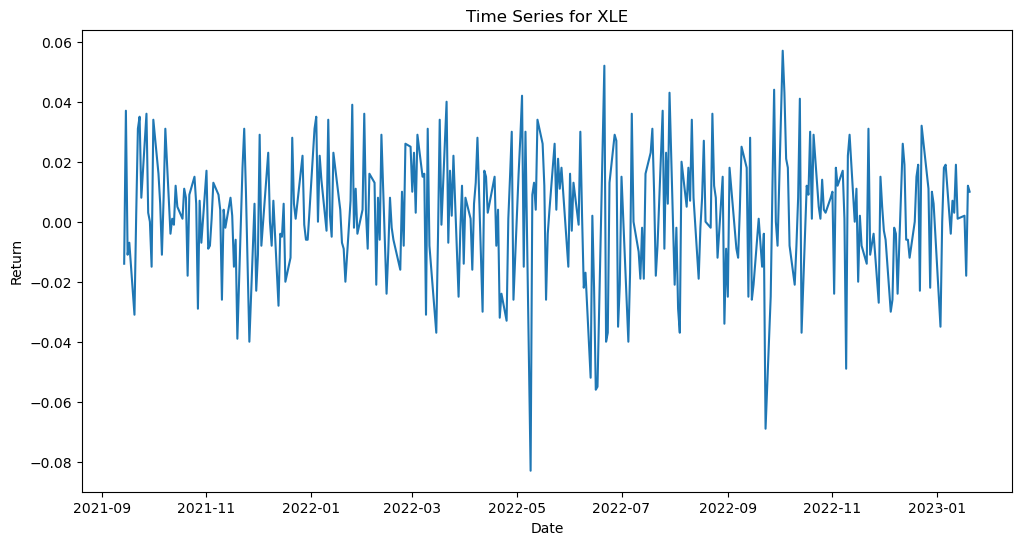

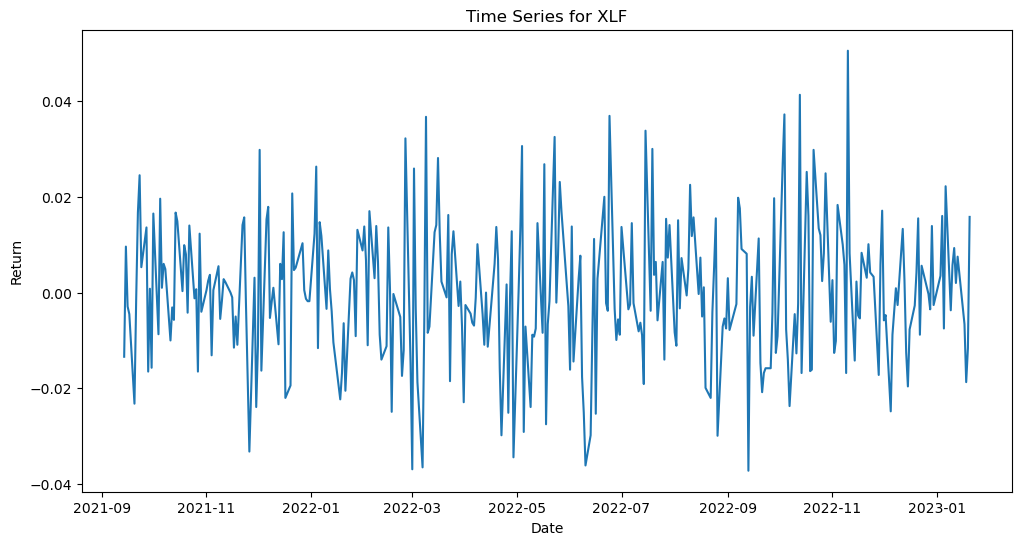

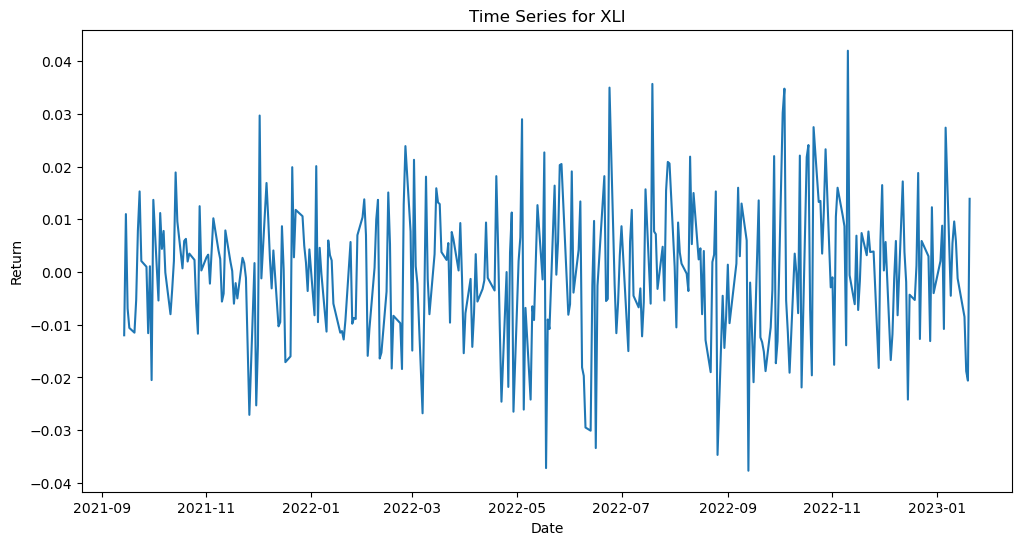

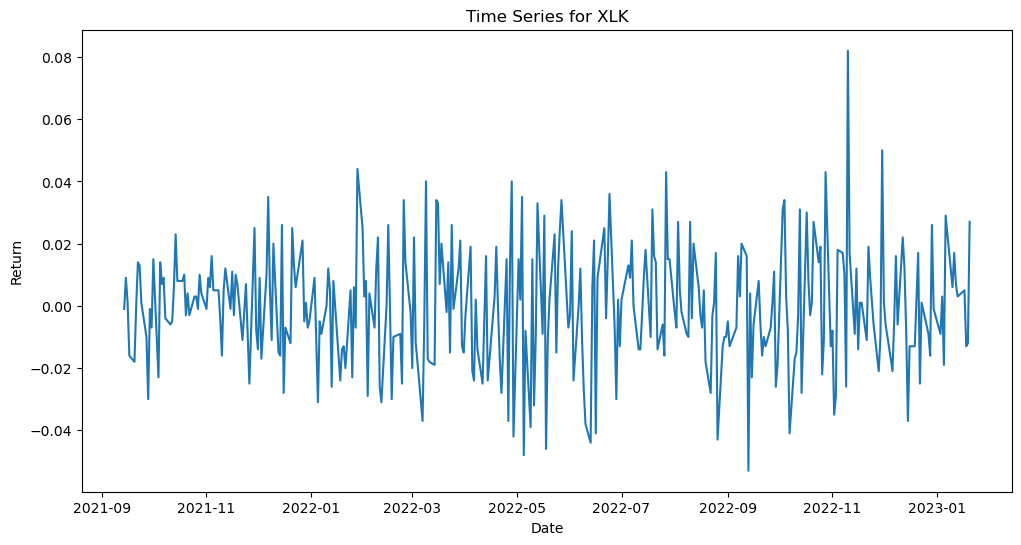

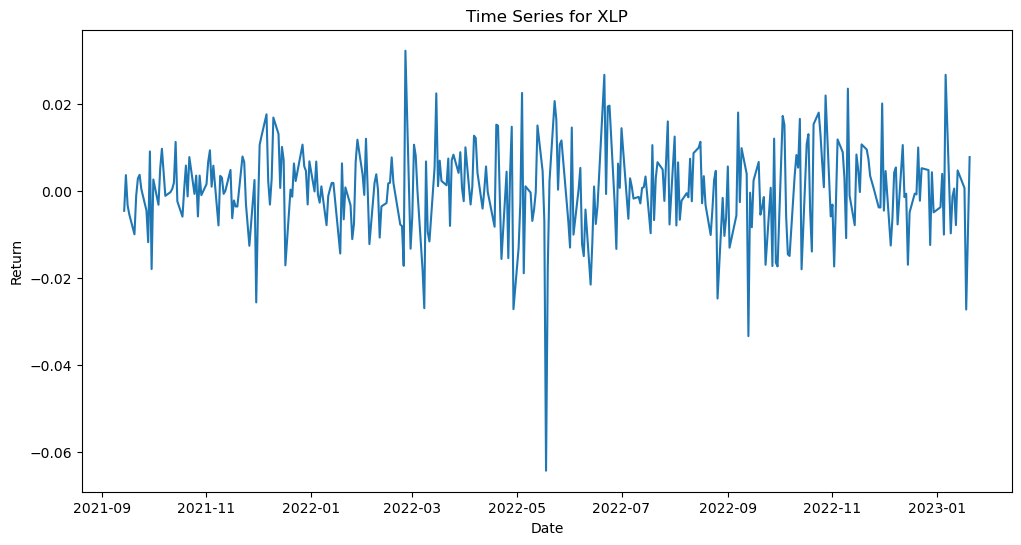

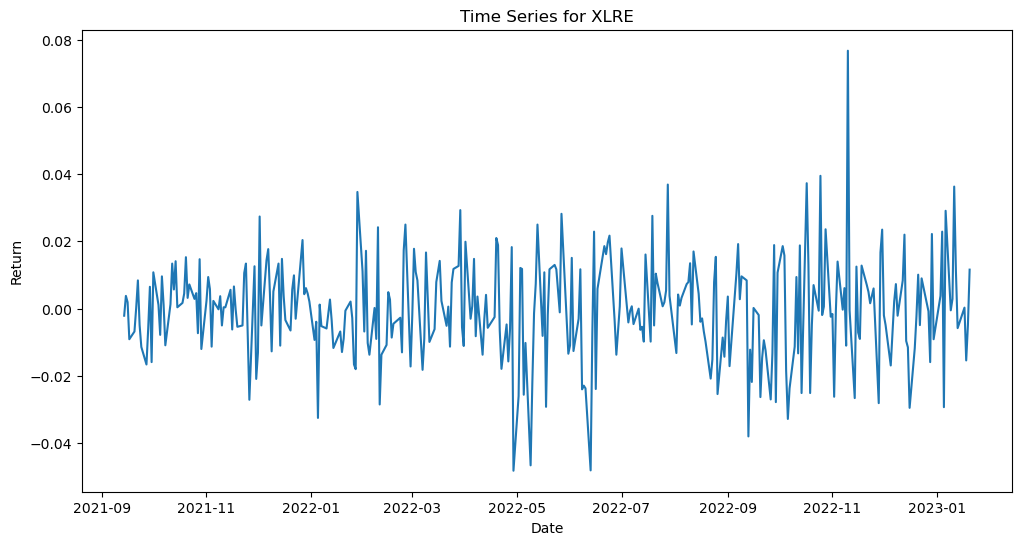

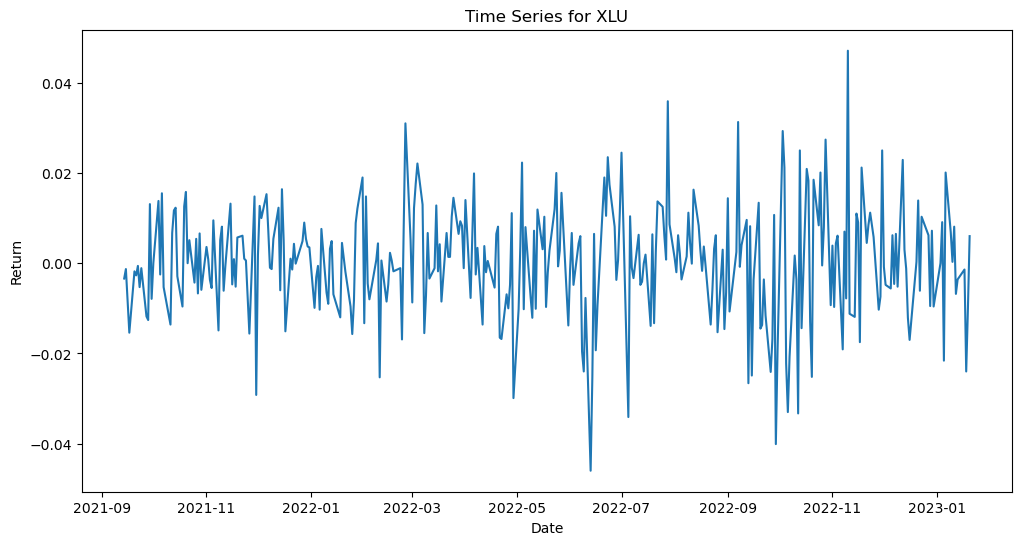

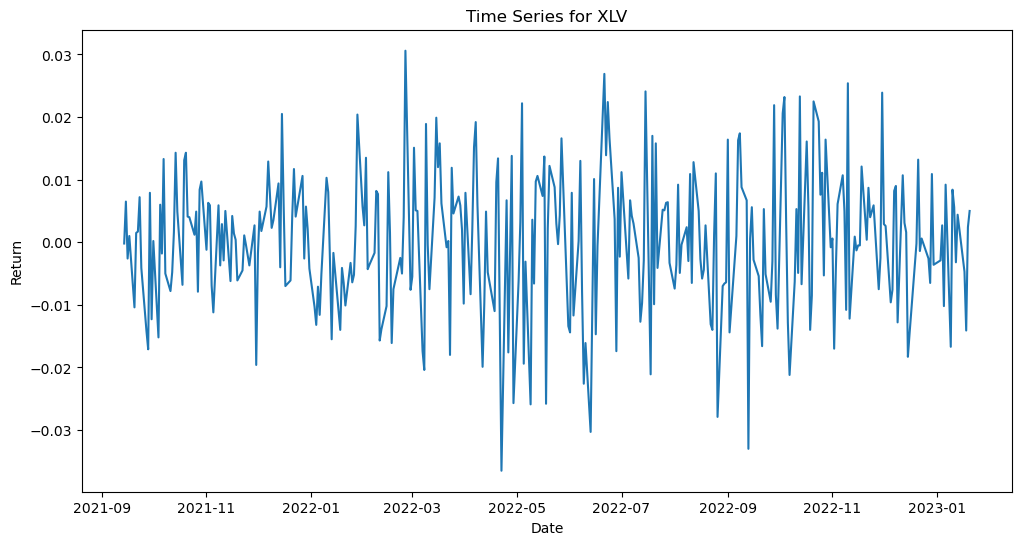

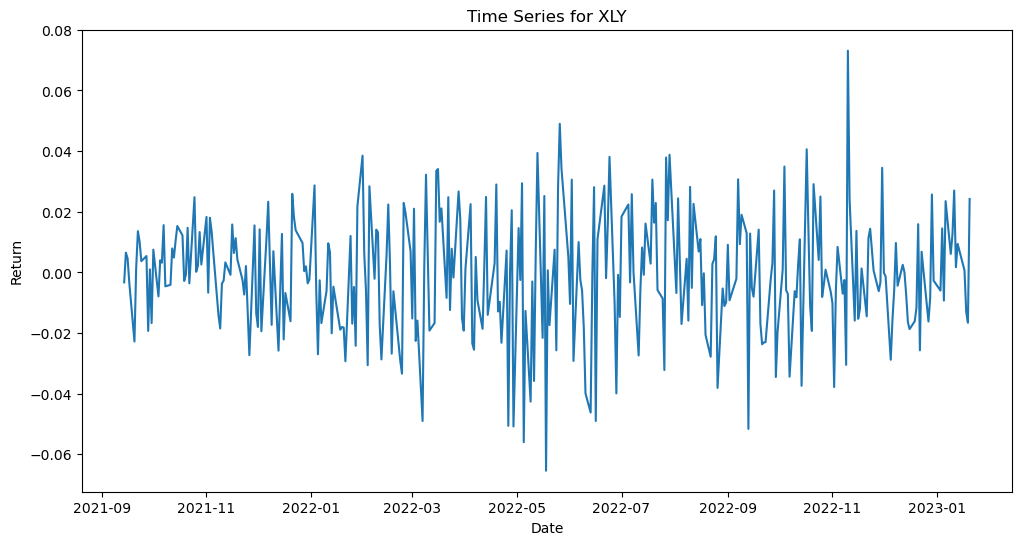

In [19]:
ticker_groups = returns.groupby('Ticker')
ticker_groups
for ticker, data in ticker_groups:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data['Date'], data['Return'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.set_title(f'Time Series for {ticker}')
    plt.show()